# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# PyTorch
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# From src
from src.prepare_data import TSDataset
from src.inference import format_predictions, calculate_metrics
from src.models import GatedRecurrentUnit

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} is available.")

cpu is available.


In [3]:
# Seed
seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [4]:
# Config
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 32
EPOCHS = 20

# Data

In [5]:
# Load data
load_data = pd.read_csv('../data/electricity_load_data.csv', index_col=['datetime'], parse_dates=True)

In [6]:
load_data

,load
datetime,
2019-01-01 00:00:00,112.01
2019-01-01 01:00:00,92.44
2019-01-01 02:00:00,84.52
2019-01-01 03:00:00,75.36
2019-01-01 04:00:00,63.64
...,...
2022-05-15 19:00:00,93.25
2022-05-15 20:00:00,80.74
2022-05-15 21:00:00,78.99


<AxesSubplot: xlabel='datetime'>

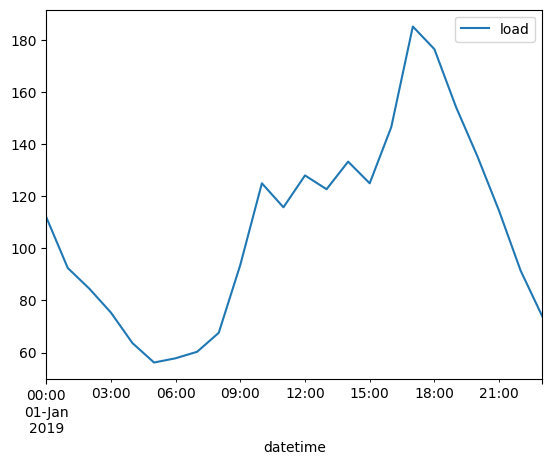

In [7]:
load_data.iloc[:24].plot()

In [8]:
# Generate target and input variables
dataset = TSDataset(dataframe=load_data, target_variable='load')
X, y = dataset.to_supervised(n_lags=23, horizon=1)

In [9]:
X.head()

,load,load-1,load-2,load-3,load-4,load-5,load-6,load-7,load-8,load-9,...,load-14,load-15,load-16,load-17,load-18,load-19,load-20,load-21,load-22,load-23
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 23:00:00,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,124.94,133.26,...,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44,112.01
2019-01-02 00:00:00,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,124.94,...,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52,92.44
2019-01-02 01:00:00,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,146.50,...,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36,84.52
2019-01-02 02:00:00,51.65,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,185.08,...,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64,75.36
2019-01-02 03:00:00,49.20,51.65,54.35,61.68,73.96,91.42,114.38,135.19,154.26,176.40,...,122.67,127.97,115.74,124.95,93.66,67.60,60.33,57.83,56.20,63.64


In [10]:
y.head()

,load+1
datetime,
2019-01-01 23:00:00,61.68
2019-01-02 00:00:00,54.35
2019-01-02 01:00:00,51.65
2019-01-02 02:00:00,49.20
2019-01-02 03:00:00,50.60


In [11]:
print(f'Target Variable Shape: {y.shape}\nInput Variables Shape: {X.shape}')

Target Variable Shape: (29520, 1)
Input Variables Shape: (29520, 24)


In [12]:
test_ratio = 0.2
val_ratio = test_ratio / (1-test_ratio)

In [13]:
# Split set once for test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)

# Split once more for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)

In [14]:
# Reshape to 2D
y_train = y_train.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)


print(f'Train Data Shape:\t{X_train.shape}\t{y_train.shape}')
print(f'Validation Data Shape:\t{X_val.shape}\t{y_val.shape}')
print(f'Test Data Shape:\t{X_test.shape}\t{y_test.shape}')

Train Data Shape:	(17712, 24)	(17712, 1)
Validation Data Shape:	(5904, 24)	(5904, 1)
Test Data Shape:	(5904, 24)	(5904, 1)


In [15]:
# Scale data
scaler = StandardScaler()

# Scale X
X_train_scl = scaler.fit_transform(X_train)
X_val_scl = scaler.transform(X_val)
X_test_scl = scaler.transform(X_test)

# Scale y
y_train_scl = scaler.fit_transform(y_train)
y_val_scl = scaler.transform(y_val)
y_test_scl = scaler.transform(y_test)

In [16]:
# Create Tensors out of the data
train_features = torch.Tensor(X_train_scl)
train_targets = torch.Tensor(y_train_scl)
val_features = torch.Tensor(X_val_scl)
val_targets = torch.Tensor(y_val_scl)
test_features = torch.Tensor(X_test_scl)
test_targets = torch.Tensor(y_test_scl)

# Torch Tensor Datasets
train_ds = TensorDataset(train_features, train_targets)
val_ds = TensorDataset(val_features, val_targets)
test_ds = TensorDataset(test_features, test_targets)

# Torch DataLoaders
train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
val = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_one = DataLoader(test_ds, batch_size=1, shuffle=False, drop_last=True)

# PyTorch Training Loop

In [17]:
class TrainingLoop:
    """Basic PyTorch Training Loop"""
    
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
        
    def train_step(self, x, y):
        # Train mode
        self.model.train()
        
        # Predict
        y_hat = self.model(x)
        
        # Compute loss
        loss = self.loss_fn(y, y_hat)
        
        # Compute gradients
        loss.backward()
        
        # Update 
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    
    def train(self, train, val, batch_size=BATCH_SIZE, n_epochs=EPOCHS, n_features=1):
        #model_path = f'models/{self.model.__class__.__name__ }_{datetime.now().strftime("%Y%m%d%H%M%S")}.pt'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)
            
            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    y_hat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, y_hat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if (epoch <= 50) | (epoch % 100 == 0):
                print(
                    f'[{epoch} / {n_epochs}] Training Loss: {training_loss:.4f}\t Validation Loss: {validation_loss:.4f}'
                )
        
        #torch.save(self.model.state_dict(), model_path)

    
    def evaluate(self, test, batch_size=1, n_features=1):
        
        with torch.no_grad():
            predictions = []
            values = []
                
            for x_test, y_test in test:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                y_hat = self.model(x_test)
                predictions.append(y_hat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        
        return predictions, values

    
    def plot_loss(self):
        fig = plt.figure(figsize=(10,6))
        x = [ep for ep in range(1, EPOCHS+1)]
        plt.plot(x, self.train_losses, label="Training Loss")
        plt.plot(x, self.val_losses, label='Validation Loss')
        plt.xticks(x)
        plt.legend()
        plt.title('Training & Validation Losses')
        plt.show()
        plt.close()

In [18]:
# Hyperparameters
input_size = len(X_train.columns) # 24
output_size = y_train.shape[1] # 1
hidden_size = 64
num_layers = 1
dropout_prob = 0
learning_rate = 1e-2


In [19]:
# Build model
model = GatedRecurrentUnit(
    hidden_size = hidden_size,
    num_rnn_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    dropout = dropout_prob,
    device = device
    )


print(model)

GatedRecurrentUnit(
  (gru): GRU(24, 64, batch_first=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)


In [20]:
# Define Loss function and Optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [21]:
# Instantiate TrainingLoop and start training
train_loop = TrainingLoop(model=model, loss_fn=loss_fn, optimizer=optimizer)

train_loop.train(train, val, batch_size=BATCH_SIZE, n_epochs=EPOCHS, n_features=input_size)

[1 / 20] Training Loss: 0.1391	 Validation Loss: 0.0693
[2 / 20] Training Loss: 0.0675	 Validation Loss: 0.0579
[3 / 20] Training Loss: 0.0578	 Validation Loss: 0.0527
[4 / 20] Training Loss: 0.0519	 Validation Loss: 0.0497
[5 / 20] Training Loss: 0.0479	 Validation Loss: 0.0479
[6 / 20] Training Loss: 0.0452	 Validation Loss: 0.0469
[7 / 20] Training Loss: 0.0432	 Validation Loss: 0.0463
[8 / 20] Training Loss: 0.0418	 Validation Loss: 0.0460
[9 / 20] Training Loss: 0.0407	 Validation Loss: 0.0459
[10 / 20] Training Loss: 0.0398	 Validation Loss: 0.0459
[11 / 20] Training Loss: 0.0390	 Validation Loss: 0.0459
[12 / 20] Training Loss: 0.0384	 Validation Loss: 0.0459
[13 / 20] Training Loss: 0.0379	 Validation Loss: 0.0458
[14 / 20] Training Loss: 0.0374	 Validation Loss: 0.0457
[15 / 20] Training Loss: 0.0370	 Validation Loss: 0.0456
[16 / 20] Training Loss: 0.0366	 Validation Loss: 0.0455
[17 / 20] Training Loss: 0.0363	 Validation Loss: 0.0453
[18 / 20] Training Loss: 0.0360	 Validat

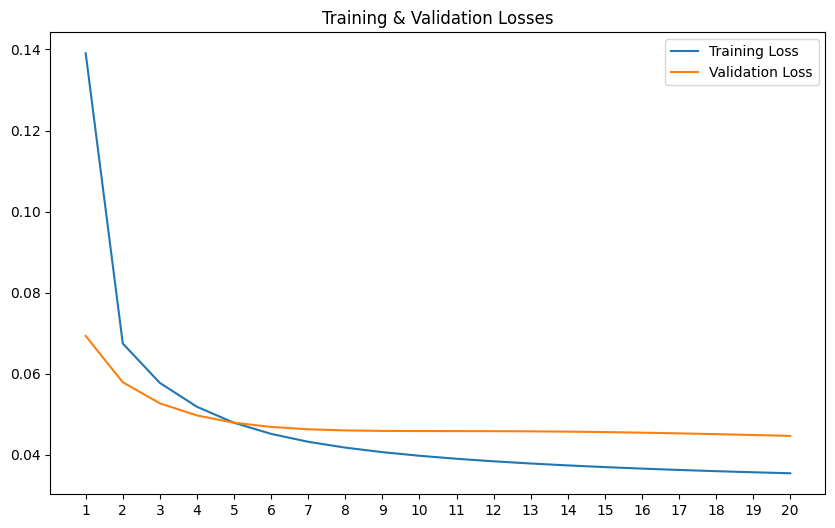

In [22]:
# Plot Training and Validation Loss
train_loop.plot_loss()

# Evaluation

In [23]:
# Run predictions using test data
predictions, labels = train_loop.evaluate(
    test,
    batch_size=BATCH_SIZE,
    n_features=input_size
)

In [24]:
# Values and predictions will be scaled -> must be inversely scaled back
df_result = format_predictions(predictions, labels, X_test, scaler)
df_result

,labels,prediction
datetime,,
2021-09-11 23:00:00,51.320000,48.240154
2021-09-12 00:00:00,45.309998,42.694656
2021-09-12 01:00:00,44.610001,41.534676
2021-09-12 02:00:00,45.079998,43.354610
2021-09-12 03:00:00,46.299999,45.422558
...,...,...
2022-05-15 02:00:00,39.610001,42.106163
2022-05-15 03:00:00,40.270000,43.433544
2022-05-15 04:00:00,43.659996,50.155724


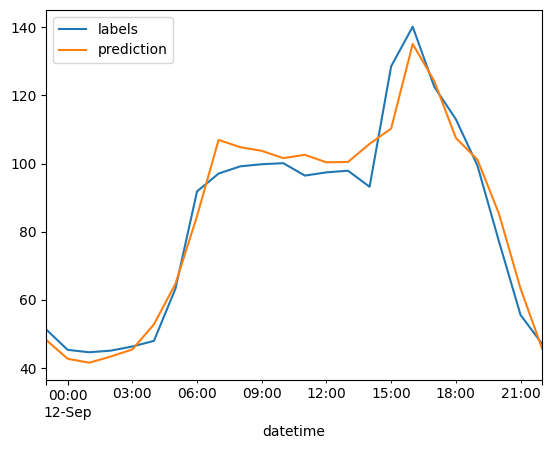

In [25]:
df_result.iloc[:24].plot()
plt.show()

In [26]:
# Calculate error/performance metrics
metrics = calculate_metrics(df_result["labels"], df_result["prediction"])

Mean Absolute Error: 5.3071523
Mean Absolute % Error: 6.213662028312683
Symmetric Mean Absolute % Error: 6.213662028312683
Root Mean Squared Error: 6.980669579074545
R^2 Score: 0.9500598096875524
